In [1]:
#Predict whether a building is high performance or not using machine learning algorithms such as desicion tree and svm
from IntelligentBuildingPerformanceDesign.AIBPD.data.preprocessing import PreprocessingCBECS
from IntelligentBuildingPerformanceDesign.AIBPD.data.database import Database
import numpy as np
from sklearn import tree
import pandas as pd

In [2]:
database=Database()
CBECS_DF=database.select('CBECS2012')
Preproc=PreprocessingCBECS()
CBECS_DF=CBECS_DF[CBECS_DF['HDD65']>=3000]
CBECS_DF=CBECS_DF.reindex(range(CBECS_DF.shape[0]+1))
CBECS_DF=Preproc.forHEHSClf(CBECS_DF)

Load CBECS2012 successfully


C:\Users\tzcha\Documents\IntelligentBuildingPerformanceDesign\AIBPD\data\preprocessing.py:183: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  dataDF=dataDF.convert_objects(convert_numeric=True)
C:\Users\tzcha\Documents\IntelligentBuildingPerformanceDesign\AIBPD\data\preprocessing.py:130: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataDF[dataDF['EUIHeating']>=0][dataDF['EUIHeating']<=1000]


dataDF in preprocessing shape (2185, 717)
top10 0.9826086956521739 top25 5.87144 top75 43.49049462365591 top90 84.40054571428571


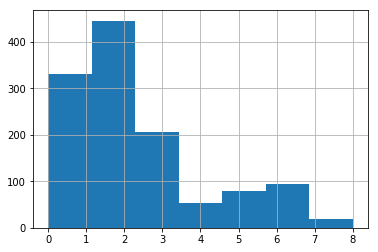

In [7]:
CBECS_DF=CBECS_DF.dropna()
CBECS_DF['MAINCL'].hist(bins=7)

In [3]:
HP=CBECS_DF[CBECS_DF['HEHS']==1.0]
MP=CBECS_DF[CBECS_DF['HEHS']==2.0]
LP=CBECS_DF[CBECS_DF['HEHS']==0.0]
m1=HP.shape[0]
m2=MP.shape[0]
m3=LP.shape[0]
print(HP['EUIHeating'].mean(),HP['EUIHeating'].std())
print(MP['EUIHeating'].mean(),MP['EUIHeating'].std())
print(LP['EUIHeating'].mean(),LP['EUIHeating'].std())

3.240613154382602 1.435569502010204
21.968377380666812 10.581740168569784
61.390763156588555 11.883457129885988


In [4]:
def cumulativeBar(axN,n22,legends):
    dataN=n22[np.any(n22>0.0, axis=1)]
    print('legend num',len(legends),'row of data',dataN.shape)
    ncolumns=dataN.shape[1]
    ind=range(ncolumns)
    axN.bar(ind,dataN[0,:],label=str(legends[0]))
    sumN=dataN[0,:]
    for i in range(1,dataN.shape[0]):
        if i>=2:
            sumN+=dataN[i-1,:]
        axN.bar(ind,dataN[i,:],bottom=sumN,label=str(legends[i]))
    return axN

In [5]:
def getLegend(index,binsArr,legendDict):
    legendslist=[]
    keys=list(legendDict.keys())
    for i in range(index.shape[0]):
        if index[i]:
            v1=binsArr[i]
            v2=binsArr[i+1]
            for j in keys:
                if float(j)>=v1 and float(j)<=v2:
                    legendslist.append(legendDict[j])
                    keys.remove(j)
    return legendslist    

In [6]:
def highInfluenceFactorsDetect(name_str,bin_num,HP,MP,LP,m1,m2,m3):
    (n_buildingAreaCategory1, bins_buildingAreaCategory1, patches) = plt.hist(HP[name_str],bins=range(bin_num),density=False,weights= [1./m1] * m1)
    (n_buildingAreaCategory2, bins_buildingAreaCategory2, patches) = plt.hist(MP[name_str],bins=range(bin_num),density=False,weights= [1./m2] * m2)
    (n_buildingAreaCategory3, bins_buildingAreaCategory3, patches) = plt.hist(LP[name_str],bins=range(bin_num),density=False,weights= [1./m3] * m3)
    diff=(n_buildingAreaCategory1-n_buildingAreaCategory3)
    diff_max=np.amax(diff)
    print('Attributes Name',name_str,'max diff',diff_max)

In [7]:
def featureAnalysis(attri_name,bin_num,legends_dict_buildingAreaCategory,HP,MP,LP,m1,m2,m3):
    (n_buildingAreaCategory1, bins_buildingAreaCategory1, patches) = plt.hist(HP[attri_name],bins=range(bin_num),density=False,weights= [1./m1] * m1)
    (n_buildingAreaCategory2, bins_buildingAreaCategory2, patches) = plt.hist(MP[attri_name],bins=range(bin_num),density=False,weights= [1./m2] * m2)
    (n_buildingAreaCategory3, bins_buildingAreaCategory3, patches) = plt.hist(LP[attri_name],bins=range(bin_num),density=False,weights= [1./m3] * m3)
    diff=(n_buildingAreaCategory1-n_buildingAreaCategory3)
    diff_max=np.amax(diff)
    print('Attributes Name',attri_name,'max diff',diff_max)
    
    n_stacked_buildingAreaCategory=np.vstack((n_buildingAreaCategory1,n_buildingAreaCategory2))
    n_stacked_buildingAreaCategory=np.vstack((n_stacked_buildingAreaCategory,n_buildingAreaCategory3)).T
    index_buildingAreaCategory=np.any(n_stacked_buildingAreaCategory>0.0, axis=1)

    fig_buildingAreaCategory=plt.figure(figsize=(10,6))
    ax2=fig_buildingAreaCategory.add_subplot(1,1,1)
    ax2.set_ylabel('Percentage')
    ax2.set_title(attri_name+' distributions in different building groups')
    
    legendList_buildingAreaCategory=getLegend(index_buildingAreaCategory,bins_buildingAreaCategory1,legends_dict_buildingAreaCategory)
    cumulativeBar(ax2,n_stacked_buildingAreaCategory,legendList_buildingAreaCategory)
    h, l = ax2.get_legend_handles_labels()
    ax2.set_xticklabels(labels=('','','Low heating energy buildings','','Medium heating energy builsings','','High heating energy buildings'))
    ax2.set_yticklabels(labels=('0','20%','40%','60%','80%','100%'))
    ax2.legend(loc='center right',bbox_to_anchor=(1.55,0.5))
    fig_buildingAreaCategory.savefig('.\\'+attri_name+"Distribution-climate3000.jpg",dpi=300,bbox_inches='tight')

In [8]:
def make_figure(n_tuple,attri_name,legends_dict_buildingAreaCategory,bins_buildingAreaCategory1,anchor=(1.35, 0.5)):
    n_buildingAreaCategory1,n_buildingAreaCategory2,n_buildingAreaCategory3=n_tuple
    n_stacked_n_buildingAreaCategory=np.vstack((n_buildingAreaCategory1,n_buildingAreaCategory2))
    n_stacked_n_buildingAreaCategory=np.vstack((n_stacked_n_buildingAreaCategory,n_buildingAreaCategory3)).T
    index_buildingAreaCategory=np.any(n_stacked_n_buildingAreaCategory>0.0, axis=1)

    fig_buildingAreaCategory=plt.figure(figsize=(10,6))
    ax2=fig_buildingAreaCategory.add_subplot(1,1,1)
    ax2.set_ylabel('Percentage')
    #ax2.set_xlabel('buildingAreaCategory')
    #legends=np.unique(HP['principleActivity'].values)
    ax2.set_title(attri_name+' distributions in different building groups')
    
    legendList_buildingAreaCategory=getLegend(index_buildingAreaCategory,bins_buildingAreaCategory1,legends_dict_buildingAreaCategory)
    #print('legend num',len(legendList_buildingAreaCategory),'row of data',n_stacked_n_buildingAreaCategory.shape)
    cumulativeBar(ax2,n_stacked_n_buildingAreaCategory,legendList_buildingAreaCategory)
    h, l = ax2.get_legend_handles_labels()
    ax2.set_xticklabels(labels=('','','Low heating energy buildings','','Medium heating energy builsings','','High heating energy buildings'))
    ax2.set_yticklabels(labels=('0','20%','40%','60%','80%','100%'))
    ax2.legend(loc='center right',bbox_to_anchor=anchor)
    fig_buildingAreaCategory.savefig('.\\'+attri_name+"Distribution-climate.jpg",dpi=300,bbox_inches='tight')

In [9]:
import matplotlib.pyplot as plt
(n_principleActivity1, bins_principleActivity1, patches) = plt.hist(HP['principleActivity'],bins=range(92),density=False,weights= [1./m1] * m1)
(n_principleActivity2, bins_principleActivity2, patches) = plt.hist(MP['principleActivity'],bins=range(92),density=False,weights= [1./m2] * m2)
(n_principleActivity3, bins_principleActivity3, patches) = plt.hist(LP['principleActivity'],bins=range(92),density=False,weights= [1./m3] * m3)
n_tuple_principleActivity=(n_principleActivity1,n_principleActivity2,n_principleActivity3)
attri_name_principleActivity='principleActivity'
legends_dict_principleActivity={1:'Vacant',2:'Office',4:'Laboratory',
              5:'Nonrefrigerated warehouse',6:'Food sales',7:'Public order and safety',8:'Outpatient health care',
            11: 'Refrigerated warehouse',12: 'Religious worship',13 : 'Public assembly',
            14:'Education',15: 'Food service',16:'Inpatient health care',17:'Nursing',18:'Lodging',
              23:'Strip shopping mall',24: 'Enclosed mall',25:'Retail other than mall',26:'Service',91: 'Other'}

legend num 19 row of data (19, 3)


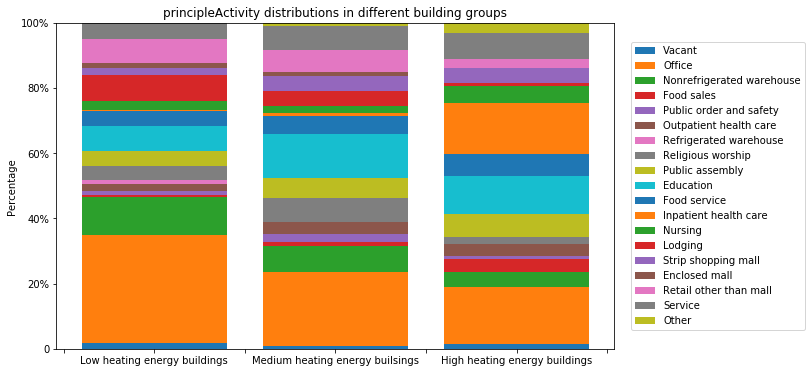

In [13]:
make_figure(n_tuple_principleActivity,attri_name_principleActivity,legends_dict_principleActivity,bins_principleActivity1,anchor=(1.35,0.5))

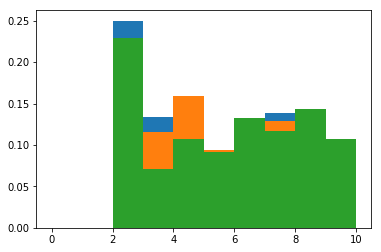

In [14]:
(n_buildingAreaCategory1, bins_buildingAreaCategory1, patches) = plt.hist(HP['buildingAreaCategory'],bins=range(11),density=False,weights= [1./m1] * m1)
(n_buildingAreaCategory2, bins_buildingAreaCategory2, patches) = plt.hist(MP['buildingAreaCategory'],bins=range(11),density=False,weights= [1./m2] * m2)
(n_buildingAreaCategory3, bins_buildingAreaCategory3, patches) = plt.hist(LP['buildingAreaCategory'],bins=range(11),density=False,weights= [1./m3] * m3)
n_tuple_buildingAreaCategory=(n_buildingAreaCategory1,n_buildingAreaCategory2,n_buildingAreaCategory3)
attri_name_buildingAreaCategory='buildingAreaCategory'
legends_dict_buildingAreaCategory={1 : '1,000 square feet or less',
2  :  '1,001 to 5,000 square feet',
3 : '5,001 to 10,000 square feet',
4 : '10,001 to 25,000 square feet',
5 : '25,001 to 50,000 square feet',
6 : '50,001 to 100,000 square feet',
7 : '100,001 to 200,000 square feet',
8 : '200,001 to 500,000 square feet',
9 : '500,001 to 1 million square feet',
10 : 'Over 1 million square feet'}

legend num 8 row of data (8, 3)


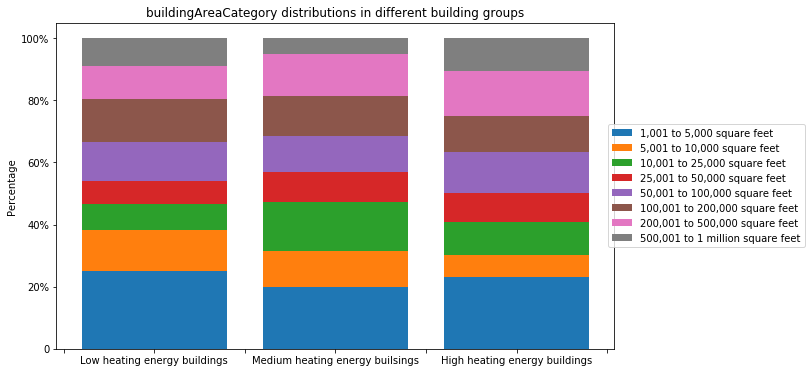

In [15]:
make_figure(n_tuple_buildingAreaCategory,attri_name_buildingAreaCategory,legends_dict_buildingAreaCategory,bins_buildingAreaCategory1,anchor=(1.35,0.5))

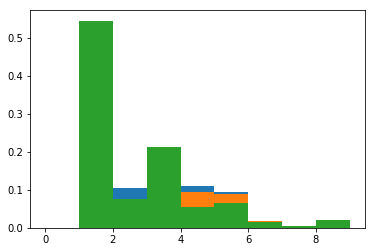

In [16]:
(n_wallConstruction1, bins_wallConstruction1, patches) =plt.hist(HP['wallConstruction'],bins=range(10),density=False,weights= [1./m1] * m1)
(n_wallConstruction2, bins_wallConstruction2, patches)= plt.hist(MP['wallConstruction'],bins=range(10),density=False,weights= [1./m2] * m2)
(n_wallConstruction3, bins_wallConstruction3, patches) =plt.hist(LP['wallConstruction'],bins=range(10),density=False,weights= [1./m3] * m3)
n_tuple_wallConstruction=(n_wallConstruction1,n_wallConstruction2,n_wallConstruction3)
attri_name_wallConstruction='wallConstruction'
legends_dict_wallConstruction={'1' : 'Brick, stone, or stucco',
'2' : 'Pre-cast concrete panels',
'3' : 'Concrete block or poured concrete (above grade)',
'4' : 'Aluminum, asbestos, plastic, or wood materials',
'5' : 'Sheet metal panels',
'6' : 'Window or vision glass (glass that can be seen through)',
'7' : 'Decorative or construction glass',
'8' : 'No one major type',
'9' : 'Other'}

legend num 8 row of data (8, 3)


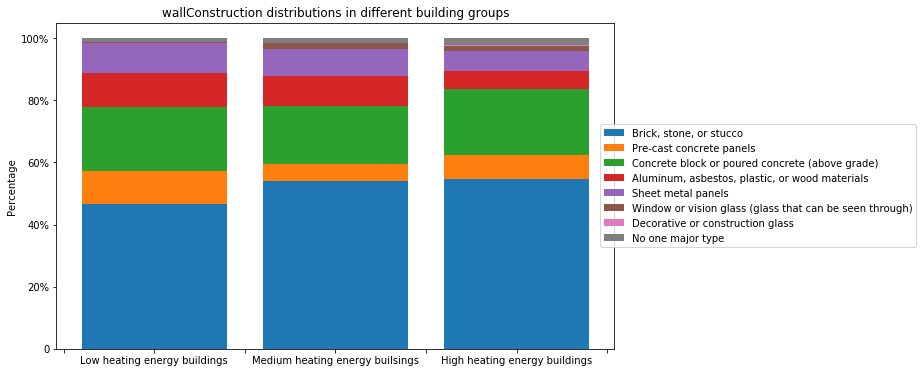

In [17]:
make_figure(n_tuple_wallConstruction,attri_name_wallConstruction,legends_dict_wallConstruction,bins_wallConstruction1,anchor=(1.55,0.5))

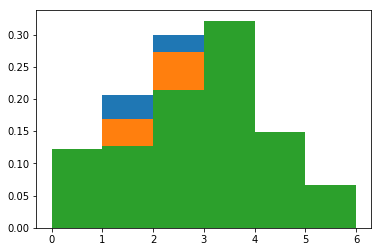

In [18]:
(n_WWR1, bins_WWR1, patches) =plt.hist(HP['WWR'],bins=range(7),density=False,weights= [1./m1] * m1)
(n_WWR2, bins_WWR2, patches) =plt.hist(MP['WWR'],bins=range(7),density=False,weights= [1./m2] * m2)
(n_WWR3, bins_WWR3, patches) =plt.hist(LP['WWR'],bins=range(7),density=False,weights= [1./m3] * m3)
n_tuple_WWR=(n_WWR1,n_WWR2,n_WWR3)
attri_name_WWR='WWR'
legends_dict_WWR={1 : '1 percent or less',
2 : '2 to 10 percent',
3 : '11 to 25 percent',
4 : '26 to 50 percent',
5 : '51 to 75 percent',
6 : '76 to 100 percent',
0 : 'Not applicable'}

legend num 7 row of data (6, 3)


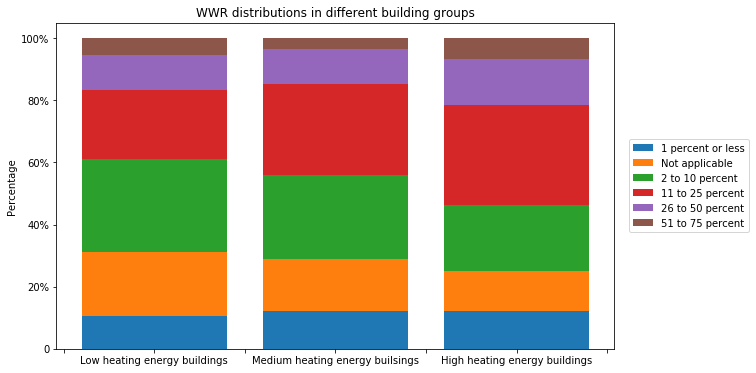

In [19]:
make_figure(n_tuple_WWR,attri_name_WWR,legends_dict_WWR,bins_WWR1,anchor=(1.25,0.5))

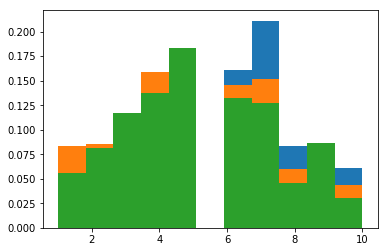

In [20]:
(n_yrConstructionCategory1, bins_yrConstructionCategory1, patches)=plt.hist(HP['yrConstructionCategory'],bins=11,density=False,weights= [1./m1] * m1)
(n_yrConstructionCategory2, bins_yrConstructionCategory2, patches)=plt.hist(MP['yrConstructionCategory'],bins=11,density=False,weights= [1./m2] * m2)
(n_yrConstructionCategory3, bins_yrConstructionCategory3, patches)=plt.hist(LP['yrConstructionCategory'],bins=11,density=False,weights= [1./m3] * m3)
n_tuple_yrConstructionCategory=(n_yrConstructionCategory1,n_yrConstructionCategory2,n_yrConstructionCategory3)
attri_name_yrConstructionCategory='yrConstructionCategory'
legends_dict_yrConstructionCategory={1 : 'Before 1920',
2 :'1920 to 1945',
3 : '1946 to 1959',
4 : '1960 to 1969',
5 : '1970 to 1979',
6: '1980 to 1989',
7 : '1990 to 1999',
8 : '2000 to 2003',
9 : '2004 to 2007',
10 : '2008 to 2012'}

legend num 10 row of data (10, 3)


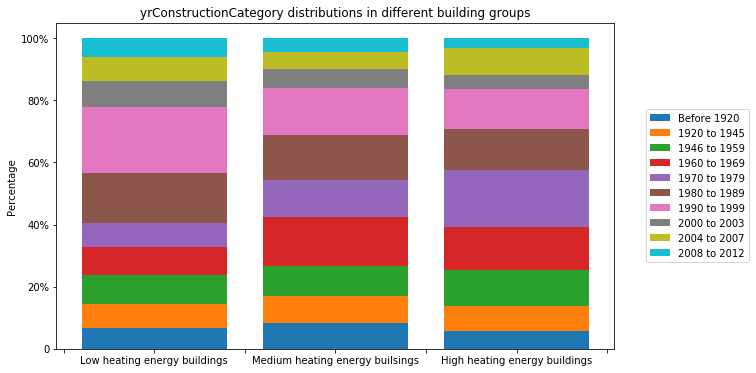

In [21]:
make_figure(n_tuple_yrConstructionCategory,attri_name_yrConstructionCategory,legends_dict_yrConstructionCategory,bins_yrConstructionCategory1,anchor=(1.25,0.5))

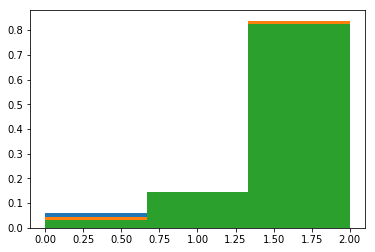

In [22]:
(n_insulationUpgrade1, bins_insulationUpgrade1, patches)=plt.hist(HP['insulationUpgrade'],bins=3,density=False,weights= [1./m1] * m1)
(n_insulationUpgrade2, bins_insulationUpgrade2, patches)=plt.hist(MP['insulationUpgrade'],bins=3,density=False,weights= [1./m2] * m2)
(n_insulationUpgrade3, bins_insulationUpgrade3, patches)=plt.hist(LP['insulationUpgrade'],bins=3,density=False,weights= [1./m3] * m3)
n_tuple_insulationUpgrade=(n_insulationUpgrade1,n_insulationUpgrade2,n_insulationUpgrade3)
attri_name_insulationUpgrade='insulationUpgrade'
legends_dict_insulationUpgrade={1 : 'Yes',2 : 'No',0 : 'Not applicable'}

legend num 3 row of data (3, 3)


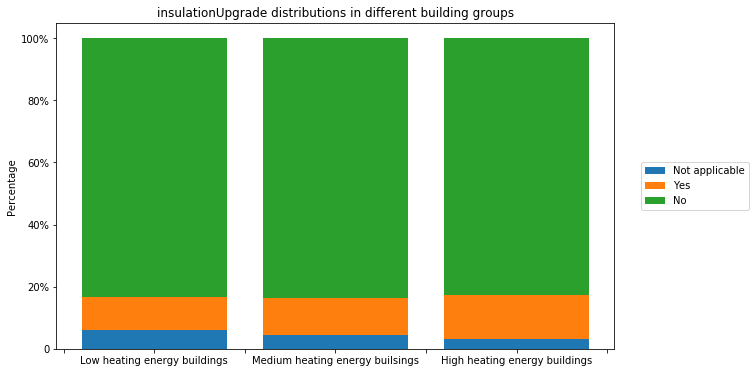

In [23]:
make_figure(n_tuple_insulationUpgrade,attri_name_insulationUpgrade,legends_dict_insulationUpgrade,bins_insulationUpgrade1,anchor=(1.25,0.5))

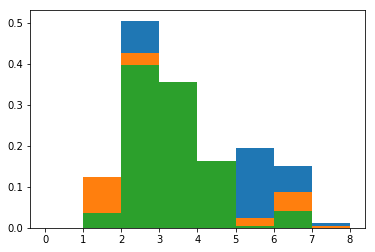

In [24]:
(n_MAINHT1, bins_MAINHT1, patches)=plt.hist(HP['MAINHT'],bins=range(9),density=False,weights= [1./m1] * m1)
(n_MAINHT2, bins_MAINHT2, patches)=plt.hist(MP['MAINHT'],bins=range(9),density=False,weights= [1./m2] * m2)
(n_MAINHT3, bins_MAINHT3, patches)=plt.hist(LP['MAINHT'],bins=range(9),density=False,weights= [1./m3] * m3)
n_tuple_MAINHT=(n_MAINHT1,n_MAINHT2,n_MAINHT3)
attri_name_MAINHT='MAINHT'
legends_dict_MAINHT={1 : 'Furnaces that heat air directly',
2 : 'Packaged central unit',
3 : 'Boilers inside',
4 : 'District heating',
5: 'Heat pumps',
6 : 'Individual space heaters',
7 : 'Other heating equipment',
0 : 'Not applicable'}

legend num 7 row of data (7, 3)


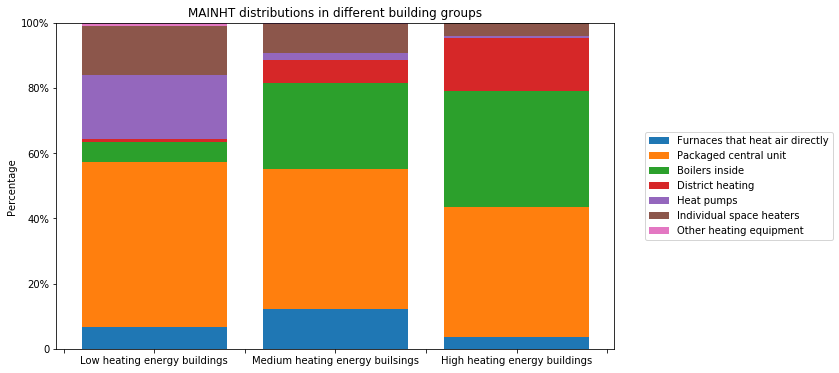

In [25]:
make_figure(n_tuple_MAINHT,attri_name_MAINHT,legends_dict_MAINHT,bins_MAINHT1,anchor=(1.4,0.5))

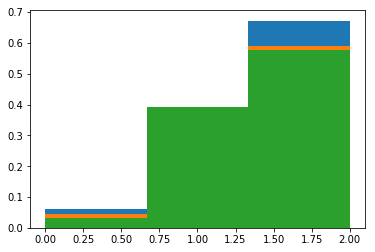

In [26]:
(n_HVACUpgrade1, bins_HVACUpgrade1, patches)=plt.hist(HP['HVACUpgrade'],bins=3,density=False,weights= [1./m1] * m1)
(n_HVACUpgrade2, bins_HVACUpgrade2, patches)=plt.hist(MP['HVACUpgrade'],bins=3,density=False,weights= [1./m2] * m2)
(n_HVACUpgrade3, bins_HVACUpgrade3, patches)=plt.hist(LP['HVACUpgrade'],bins=3,density=False,weights= [1./m3] * m3)
n_tuple=(n_HVACUpgrade1,n_HVACUpgrade2,n_HVACUpgrade3)
attri_name='HVACUpgrade'
legends_dict_HVACUpgrade={1:"Yes",2:"No",0:"Missing Value"}

legend num 3 row of data (3, 3)


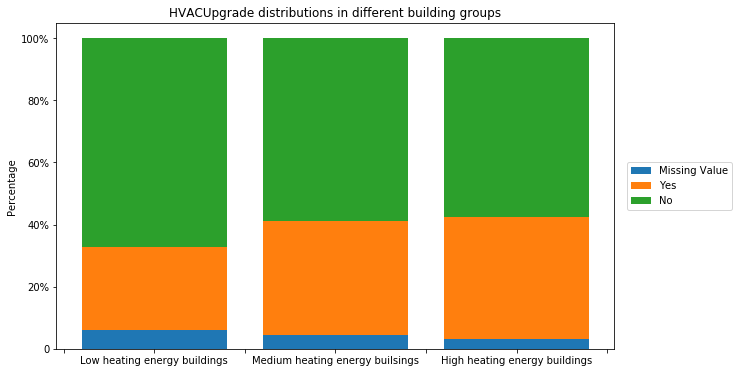

In [27]:
make_figure(n_tuple,attri_name,legends_dict_HVACUpgrade,bins_HVACUpgrade1,anchor=(1.22,0.5))

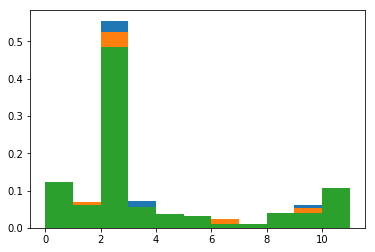

In [28]:
(n_buildingShape1, bins_buildingShape1, patches)=plt.hist(HP['buildingShape'],bins=range(12),density=False,weights= [1./m1] * m1)
(n_buildingShape2, bins_buildingShape2, patches)=plt.hist(MP['buildingShape'],bins=range(12),density=False,weights= [1./m2] * m2)
(n_buildingShape3, bins_buildingShape3, patches)=plt.hist(LP['buildingShape'],bins=range(12),density=False,weights= [1./m3] * m3)
n_tuple_buildingShape=(n_buildingShape1,n_buildingShape2,n_buildingShape3)
attri_name_buildingShape='buildingShape'
legends_dict_buildingShape={1 : 'Square',
2 : 'Wide rectangle',
3 : 'Narrow rectangle',
4 : 'Rectangle',
5 : '"H" shaped',
6: '"U" shaped',
7: '"E" shaped',
8: '"T" shaped',
9 : '"L" shaped',
10 :'"+" or cross shaped',
11 : 'Other shape',
0 :'Not applicable'}

legend num 12 row of data (11, 3)


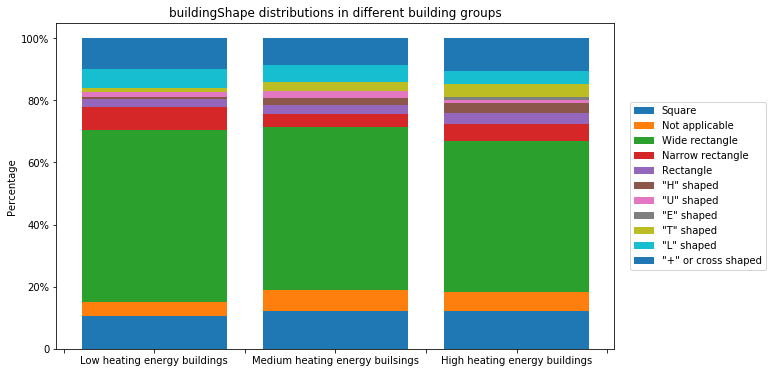

In [29]:
make_figure(n_tuple_buildingShape,attri_name_buildingShape,legends_dict_buildingShape,bins_buildingShape1,anchor=(1.28,0.5))

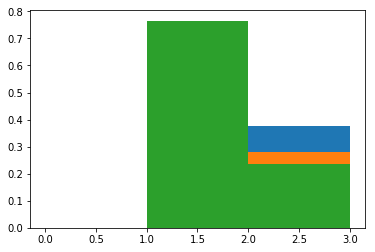

In [30]:
(n_OPNWE1, bins_OPNWE1, patches)=plt.hist(HP['OPNWE'],bins=range(4),density=False,weights= [1./m1] * m1)
(n_OPNWE2, bins_OPNWE2, patches)=plt.hist(MP['OPNWE'],bins=range(4),density=False,weights= [1./m2] * m2)
(n_OPNWE3, bins_OPNWE3, patches)=plt.hist(LP['OPNWE'],bins=range(4),density=False,weights= [1./m3] * m3)
n_tuple_OPNWE=(n_OPNWE1,n_OPNWE2,n_OPNWE3)
attri_name_OPNWE='OPNWE'
legends_dict_OPNWE={1 :'Yes',
2: 'No',
0:'Missing'}

legend num 2 row of data (2, 3)


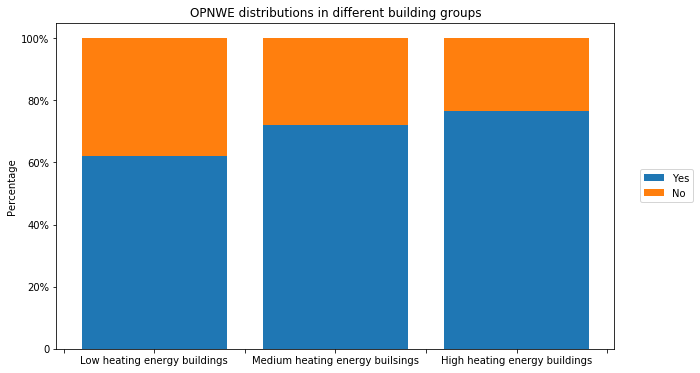

In [31]:
make_figure(n_tuple_OPNWE,attri_name_OPNWE,legends_dict_OPNWE,bins_OPNWE1,anchor=(1.15,0.5))

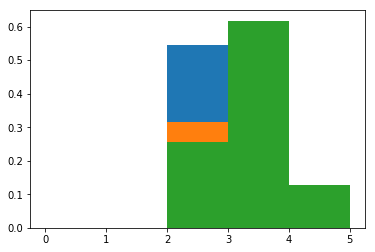

In [32]:
(n_HDD65Category1, bins_HDD65Category1, patches)=plt.hist(HP['HDD65Category'],bins=range(6),density=False,weights= [1./m1] * m1)
(n_HDD65Category2, bins_HDD65Category2, patches)=plt.hist(MP['HDD65Category'],bins=range(6),density=False,weights= [1./m2] * m2)
(n_HDD65Category3, bins_HDD65Category3, patches)=plt.hist(LP['HDD65Category'],bins=range(6),density=False,weights= [1./m3] * m3)
n_tuple_HDD65Category=(n_HDD65Category1,n_HDD65Category2,n_HDD65Category3)
attri_name_HDD65Category='HDD65Category'
legends_dict_HDD65Category={1 :'1',
2: '2',
3:'3',
4:'4',
5:'5',
0:'Missing'}

legend num 3 row of data (3, 3)


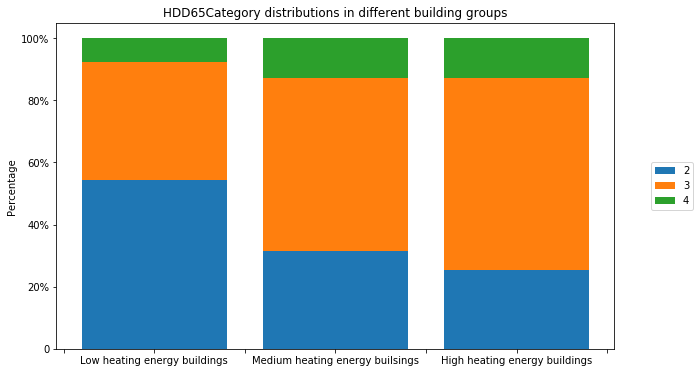

In [33]:
make_figure(n_tuple_HDD65Category,attri_name_HDD65Category,legends_dict_HDD65Category,bins_HDD65Category1,anchor=(1.15,0.5))

legend num 6 row of data (5, 3)


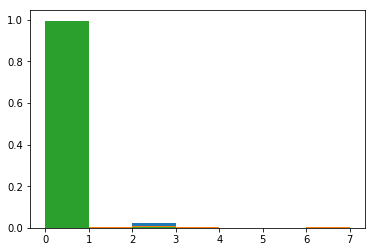

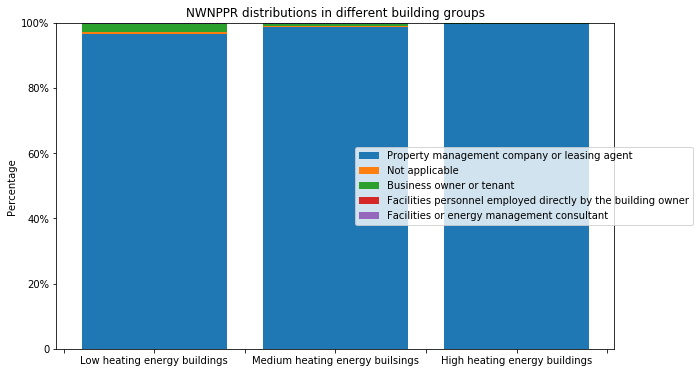

In [34]:
(n_NWNPPR1, bins_NWNPPR1, patches)=plt.hist(HP['NWNPPR'],bins=range(8),density=False,weights= [1./m1] * m1)
(n_NWNPPR2, bins_NWNPPR2, patches)=plt.hist(MP['NWNPPR'],bins=range(8),density=False,weights= [1./m2] * m2)
(n_NWNPPR3, bins_NWNPPR3, patches)=plt.hist(LP['NWNPPR'],bins=range(8),density=False,weights= [1./m3] * m3)
n_tuple_NWNPPR=(n_NWNPPR1,n_NWNPPR2,n_NWNPPR3)
attri_name_NWNPPR='NWNPPR'
legends_dict_NWNPPR={1 : 'Property management company or leasing agent',
2 : 'Business owner or tenant',
3 : 'Facilities personnel employed directly by the building owner',
4 : 'Facilities or energy management consultant',
5 : 'Volunteer member of the organization',
6 : 'Manager with general supervisory duties',
7 : 'Other',
0 : 'Not applicable'}
make_figure(n_tuple_NWNPPR,attri_name_NWNPPR,legends_dict_NWNPPR,bins_NWNPPR1,anchor=(1.15,0.5))

legend num 3 row of data (3, 3)


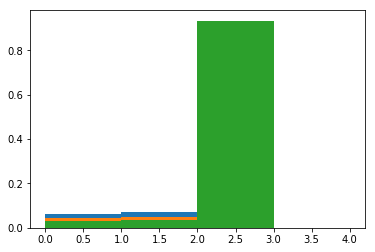

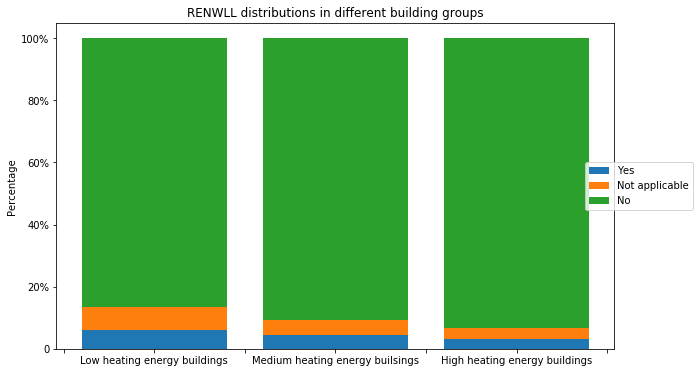

In [35]:
(n_RENWLL1, bins_RENWLL1, patches)=plt.hist(HP['RENWLL'],bins=range(5),density=False,weights= [1./m1] * m1)
(n_RENWLL2, bins_RENWLL2, patches)=plt.hist(MP['RENWLL'],bins=range(5),density=False,weights= [1./m2] * m2)
(n_RENWLL3, bins_RENWLL3, patches)=plt.hist(LP['RENWLL'],bins=range(5),density=False,weights= [1./m3] * m3)
n_tuple_RENWLL=(n_RENWLL1,n_RENWLL2,n_RENWLL3)
attri_name_RENWLL='RENWLL'
legends_dict_RENWLL={1 : 'Yes',
2 : 'No',
0 : 'Not applicable'}
make_figure(n_tuple_RENWLL,attri_name_RENWLL,legends_dict_RENWLL,bins_RENWLL1,anchor=(1.15,0.5))

legend num 4 row of data (4, 3)


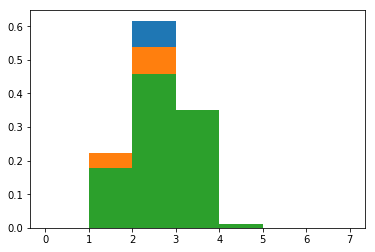

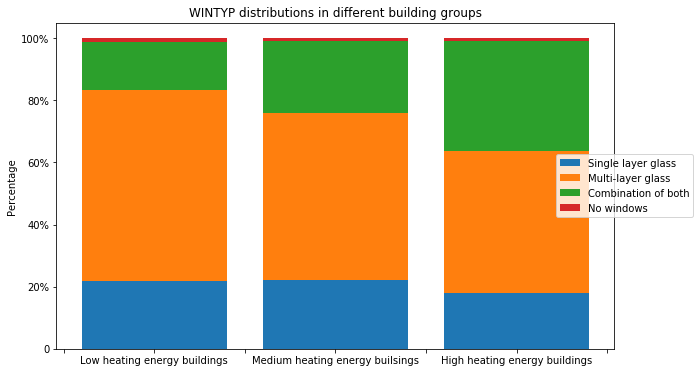

In [36]:
(n_WINTYP1, bins_WINTYP1, patches)=plt.hist(HP['WINTYP'],bins=range(8),density=False,weights= [1./m1] * m1)
(n_WINTYP2, bins_WINTYP2, patches)=plt.hist(MP['WINTYP'],bins=range(8),density=False,weights= [1./m2] * m2)
(n_WINTYP3, bins_WINTYP3, patches)=plt.hist(LP['WINTYP'],bins=range(8),density=False,weights= [1./m3] * m3)
n_tuple_WINTYP=(n_WINTYP1,n_WINTYP2,n_WINTYP3)
attri_name_WINTYP='WINTYP'
legends_dict_WINTYP={1: 'Single layer glass',2: 'Multi-layer glass',3 : 'Combination of both',
4 : 'No windows'}
make_figure(n_tuple_WINTYP,attri_name_WINTYP,legends_dict_WINTYP,bins_WINTYP1,anchor=(1.15,0.5))

In [37]:
import pandas as pd
HP['HEATPC']=pd.cut(HP['HEATP'],5,labels=range(5))
MP['HEATPC']=pd.cut(MP['HEATP'],5,labels=range(5))
LP['HEATPC']=pd.cut(LP['HEATP'],5,labels=range(5))

C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

legend num 6 row of data (5, 3)


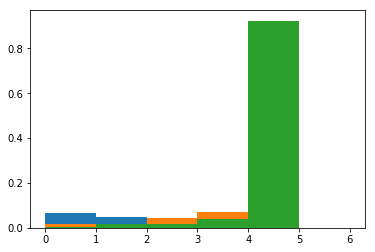

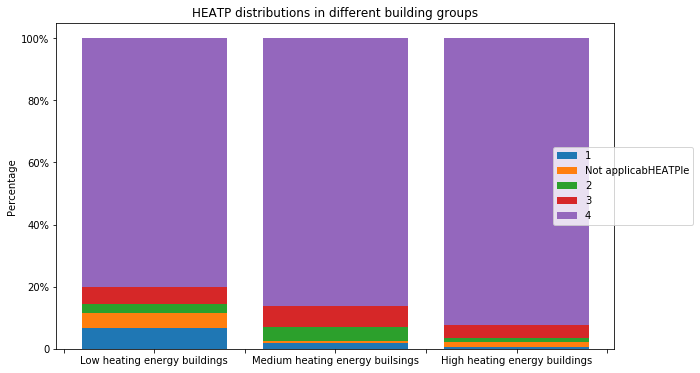

In [38]:
(n_HEATP1, bins_HEATP1, patches)=plt.hist(HP['HEATPC'],bins=range(7),density=False,weights= [1./m1] * m1)
(n_HEATP2, bins_HEATP2, patches)=plt.hist(MP['HEATPC'],bins=range(7),density=False,weights= [1./m2] * m2)
(n_HEATP3, bins_HEATP3, patches)=plt.hist(LP['HEATPC'],bins=range(7),density=False,weights= [1./m3] * m3)
n_tuple_HEATP=(n_HEATP1,n_HEATP2,n_HEATP3)
attri_name_HEATP='HEATP'
legends_dict_HEATP={1 : '1',
2 : '2',
3 : '3',
4 : '4',
5 : '5',
0 : 'Not applicabHEATPle'}
make_figure(n_tuple_HEATP,attri_name_HEATP,legends_dict_HEATP,bins_HEATP1,anchor=(1.15,0.5))

Attributes Name roofConstuction max diff 0.10816326530612264
legend num 8 row of data (8, 3)


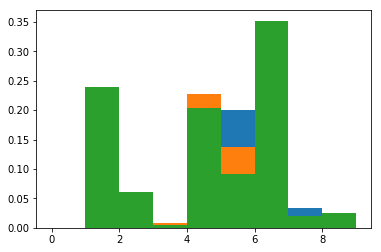

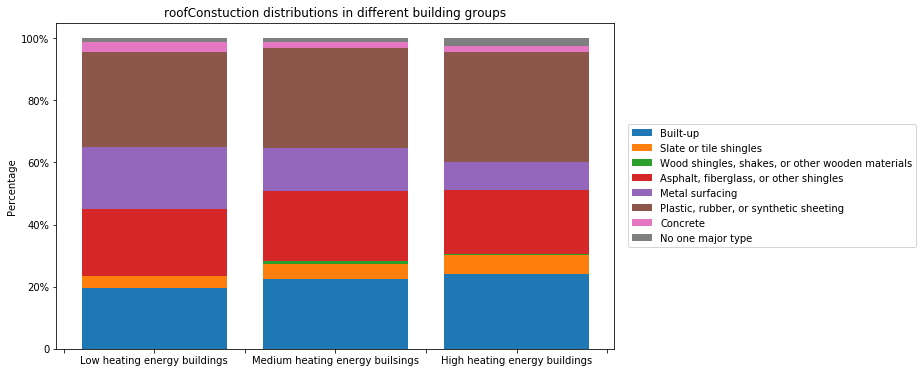

In [51]:
legends_dict_roofconstruction={1:'Built-up',
2 : 'Slate or tile shingles',
3 : 'Wood shingles, shakes, or other wooden materials',
4 : 'Asphalt, fiberglass, or other shingles',
5 : 'Metal surfacing',
6 : 'Plastic, rubber, or synthetic sheeting',
7 : 'Concrete',
8 : 'No one major type',9 : 'Other'}
bin_num_roof=10
attri_name_roof='roofConstuction'
featureAnalysis(attri_name_roof,bin_num_roof,legends_dict_roofconstruction,HP,MP,LP,m1,m2,m3)

Attributes Name insulationUpgrade max diff 0.030498866213151937
Attributes Name buildingShape max diff 0.07086167800453491
Attributes Name HVACUpgrade max diff 0.030498866213151937
Attributes Name HEATPC max diff 0.061564625850340136
Attributes Name numFloors max diff 0.06678004535147292
Attributes Name buildingAreaCategory max diff 0.06190476190476138
Attributes Name WINTYP max diff 0.157482993197278
Attributes Name RENWLL max diff 0.03650793650793645
Attributes Name HDD65Category max diff 0.2893424036281168
Attributes Name OPNWE max diff 0.14308390022675832
Attributes Name MAINHT max diff 0.18934240362811727
Attributes Name yrConstructionCategory max diff 0.08356009070294834
Attributes Name principleActivity max diff 0.15986394557823091
Attributes Name wallConstruction max diff 0.05498866213151943
Attributes Name WWR max diff 0.08571428571428441


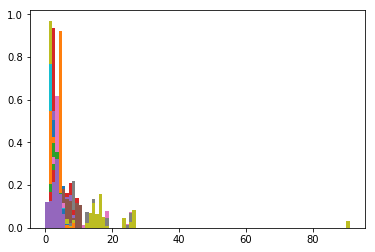

In [39]:
highInfluenceFactorsDetect('insulationUpgrade',3,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('buildingShape',12,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('HVACUpgrade',3,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('HEATPC',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('numFloors',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('buildingAreaCategory',10,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('WINTYP',5,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('RENWLL',5,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('HDD65Category',6,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('OPNWE',4,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('MAINHT',9,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('yrConstructionCategory',11,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('principleActivity',92,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('wallConstruction',10,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('WWR',7,HP,MP,LP,m1,m2,m3)

Attributes Name WKHRSC max diff 0.1367346938775498
Attributes Name OWNTYPE max diff 0.11428571428571332
Attributes Name MONUSE max diff 0.011111111111111112
Attributes Name region max diff 0.2535147392290247
Attributes Name censusRegion max diff 0.16190476190476177
Attributes Name climateZone max diff 0.2930839002267578
Attributes Name numEmployeesCategory max diff 0.067460317460317
Attributes Name RENWLL max diff 0.03650793650793645
Attributes Name WHOPPR max diff 0.007709750566893936
Attributes Name roofConstuction max diff 0.10816326530612264


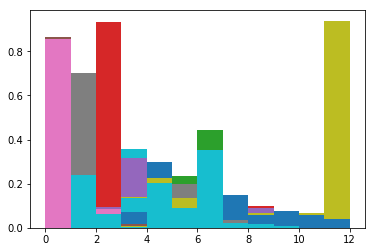

In [50]:
highInfluenceFactorsDetect('WKHRSC',8,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('OWNTYPE',9,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('MONUSE',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('region',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('censusRegion',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('climateZone',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('numEmployeesCategory',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('RENWLL',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('WHOPPR',13,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('roofConstuction',13,HP,MP,LP,m1,m2,m3)

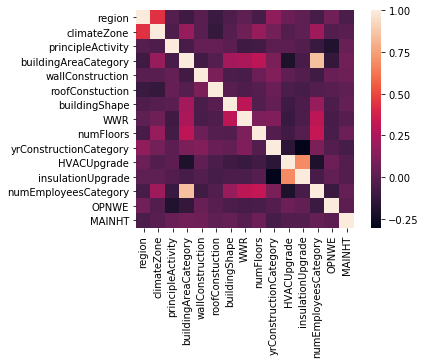

In [13]:
import matplotlib.pyplot as plt
import seaborn as sn
fig,ax = plt.subplots()
corrMatt=CBECS_DF[['region','climateZone','principleActivity','buildingAreaCategory','wallConstruction',\
                  'roofConstuction','buildingShape','WWR','numFloors','yrConstructionCategory','HVACUpgrade',\
                   'insulationUpgrade','numEmployeesCategory','OPNWE','MAINHT']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
ax=sn.heatmap(corrMatt,square=True)

In [14]:
CBECS_DF_clf=CBECS_DF[CBECS_DF['HEHS']>=0.0][CBECS_DF['HEHS']<=1.0]
CBECS_DF_clf['OCCUPYPC']=pd.cut(CBECS_DF_clf['OCCUPYP'],5,labels=range(5))

In [15]:
X=CBECS_DF_clf[['principleActivity','WWR','yrConstructionCategory','MAINHT','OPNWE','HDD65Category','WINTYP',\
                'WKHRSC','ELHT1','OCCUPYPC','STHT1']].values
Y=CBECS_DF_clf['HEHS'].values
m=CBECS_DF_clf.shape[0]
n=int(0.7*m)

In [16]:
from sklearn.metrics import classification_report
def past_ana(Y_neigh,Y):
    j=0
    k=0
    l=0
    for i in range(Y_neigh.shape[0]):
        if Y_neigh[i]==1.0 and Y[i]==1.0:
            j+=1
        elif Y_neigh[i]==1.0 and Y[i]==0.0:
            k+=1
        elif Y_neigh[i]==0.0 and Y[i]==1.0:
            l+=1
    print('(y=1,Y=1):',j,'(y=1.0,Y=0.0):',k,'(y=0.0,Y=1.0):',l,'(effective 1.0):',j/(k+1))
    print(classification_report(Y_neigh,Y))

In [17]:
from sklearn.neighbors import KNeighborsClassifier
clf_neigh = KNeighborsClassifier(n_neighbors=3)
clf_neigh.fit(X[:n,:],Y[:n])
Y_neigh=clf_neigh.predict(X[n:m,:])
print('Score',clf_neigh.score(X[n:m,:],Y[n:m]))
past_ana(Y_neigh,Y[n:m])

Score 0.7610619469026548
(y=1,Y=1): 43 (y=1.0,Y=0.0): 13 (y=0.0,Y=1.0): 14 (effective 1.0): 3.0714285714285716
             precision    recall  f1-score   support

        0.0       0.77      0.75      0.76        57
        1.0       0.75      0.77      0.76        56

avg / total       0.76      0.76      0.76       113



In [18]:
from sklearn import tree
clf_dt=tree.DecisionTreeClassifier()
clf_dt.fit(X[:n,:],Y[:n])
Y_dt=clf_dt.predict(X[n:m,:])
print(clf_dt.score(X[n:m,:],Y[n:m]))
past_ana(Y_dt,Y[n:m])

0.8230088495575221
(y=1,Y=1): 47 (y=1.0,Y=0.0): 10 (y=0.0,Y=1.0): 10 (effective 1.0): 4.2727272727272725
             precision    recall  f1-score   support

        0.0       0.82      0.82      0.82        56
        1.0       0.82      0.82      0.82        57

avg / total       0.82      0.82      0.82       113



In [19]:
from sklearn.ensemble import BaggingClassifier
clf_bag=BaggingClassifier()
clf_bag.fit(X[:n,:],Y[:n])
print(clf_bag.score(X[n:m,:],Y[n:m]))
Y_bag=clf_bag.predict(X[n:m,:])
past_ana(Y_bag,Y[n:m])

0.7522123893805309
(y=1,Y=1): 40 (y=1.0,Y=0.0): 11 (y=0.0,Y=1.0): 17 (effective 1.0): 3.3333333333333335
             precision    recall  f1-score   support

        0.0       0.80      0.73      0.76        62
        1.0       0.70      0.78      0.74        51

avg / total       0.76      0.75      0.75       113



In [21]:
from sklearn.ensemble import ExtraTreesClassifier
clf_ETC=ExtraTreesClassifier()
clf_ETC.fit(X[:n,:],Y[:n])
print(clf_ETC.score(X[n:m,:],Y[n:m]))
Y_ETC=clf_ETC.predict(X[n:m,:])
past_ana(Y_ETC,Y[n:m])

0.8230088495575221
(y=1,Y=1): 44 (y=1.0,Y=0.0): 7 (y=0.0,Y=1.0): 13 (effective 1.0): 5.5
             precision    recall  f1-score   support

        0.0       0.88      0.79      0.83        62
        1.0       0.77      0.86      0.81        51

avg / total       0.83      0.82      0.82       113



In [20]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
reg = LinearRegression()
reg.fit(X[:n,:],Y[:n])
reg.score(X[n:m,:],Y[n:m])

0.5044988855818187

In [125]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
df = pd.DataFrame({'a': [1, 1, 2, 3, 4],'b': [2, 2, 3, 2, 1],'c': [4, 6, 7, 8, 9],'d': [4, 3, 4, 5, 4]})
X1 = add_constant(CBECS_DF[['censusRegion','principleActivity','numPeoplePerAreaCate','wallConstruction','WWR','numFloors',#
            'yrConstructionCategory','insulationUpgrade',\
            #'ELHT1','NGHT1','STHT1','HWHT1',\buildingAreaCategory
            'MAINHT']])
pd.Series([variance_inflation_factor(X1.values.astype(float), i) for i in range(X1.shape[1])], index=X1.columns)

const                     36.019603
censusRegion               1.016134
principleActivity          1.027938
numPeoplePerAreaCate       1.082509
wallConstruction           1.063538
WWR                        1.088139
numFloors                  1.016744
yrConstructionCategory     1.148044
insulationUpgrade          1.084472
MAINHT                     1.019407
dtype: float64

In [45]:
from sklearn.feature_selection import VarianceThreshold
database=Database()
CBECS_DF_new=database.select('CBECS2012')

#CBECS_DF=CBECS_DF.convert_objects(convert_numeric=True)
CBECS_DF_new=CBECS_DF_new.fillna(value=0)
X=CBECS_DF_new[['principleActivity','buildingShape','WWR','wallConstruction','MAINHT',\
            'OPNWE','insulationUpgrade','insulationUpgrade','WINTYP',]].values
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)
sel.get_support(indices=True)

Load CBECS2012 successfully


array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [119]:
HP['OCCUPYPC']=pd.cut(HP['OCCUPYP'],5,labels=range(5))
MP['OCCUPYPC']=pd.cut(MP['OCCUPYP'],5,labels=range(5))
LP['OCCUPYPC']=pd.cut(LP['OCCUPYP'],5,labels=range(5))
CBECS_DF_clf['OCCUPYPC']=pd.cut(CBECS_DF_clf['OCCUPYP'],5,labels=range(5))
HP['CDD65C']=pd.qcut(HP['CDD65'],5,labels=range(5))
MP['CDD65C']=pd.qcut(MP['CDD65'],5,labels=range(5))
LP['CDD65C']=pd.qcut(LP['CDD65'],5,labels=range(5))
CBECS_DF_clf['CDD65C']=pd.qcut(CBECS_DF_clf['CDD65'],5,labels=range(5))

C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\tzcha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [120]:
from sklearn.feature_selection import SelectKBest, chi2
X_big=CBECS_DF_clf[['censusRegion','principleActivity','numPeoplePerAreaCate','wallConstruction',\
                    'WWR','numFloors','yrConstructionCategory','HVACUpgrade',\
                    'WKHRSC','HDD65','CDD65C','ELHT1','NGHT1','STHT1','HWHT1','RENWIN',\
                    'OCCUPYPC','OPNWE','MAINHT']].values
sel2=SelectKBest(chi2,k=8)
X_new=sel2.fit_transform(X_big,Y)
sel2.get_support(indices=True)

array([ 1,  5,  8,  9, 10, 11, 13, 16], dtype=int64)

Attributes Name WKHRSC max diff 0.1367346938775498
Attributes Name CDD65C max diff 0.0010204081632665396
Attributes Name ELHT1 max diff 0.6295918367346925
Attributes Name OCCUPYPC max diff 0.11122448979591915
Attributes Name STHT1 max diff 0.1257369614512477


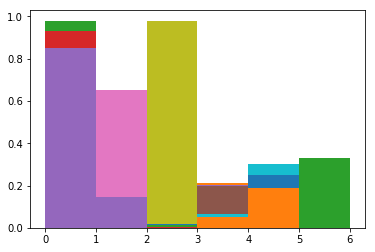

In [121]:
highInfluenceFactorsDetect('WKHRSC',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('CDD65C',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('ELHT1',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('OCCUPYPC',7,HP,MP,LP,m1,m2,m3)
highInfluenceFactorsDetect('STHT1',7,HP,MP,LP,m1,m2,m3)

Attributes Name ELHT1 max diff 0.6295918367346925
legend num 2 row of data (2, 3)


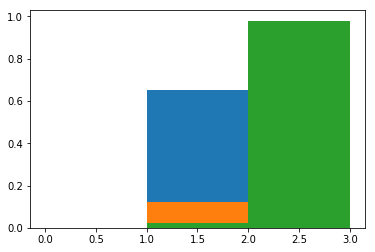

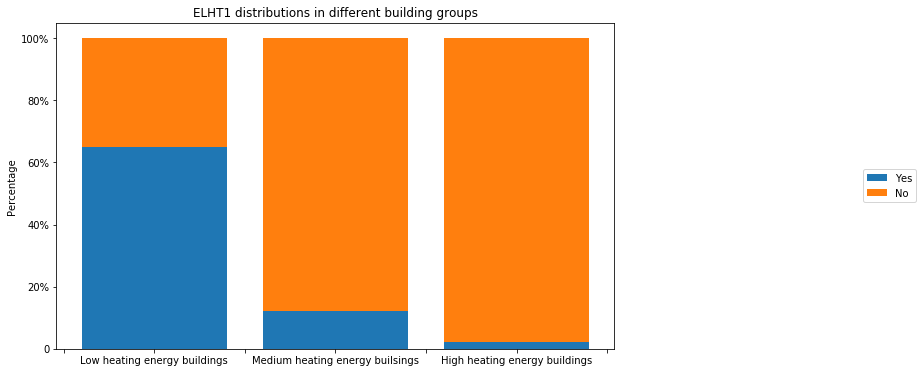

In [113]:
attri_name_ELHT1='ELHT1'
legends_dict_ELHT1={1:'Yes',2:'No',0:'Missing'}
bin_num_ELHT1=4
featureAnalysis(attri_name_ELHT1,bin_num_ELHT1,legends_dict_ELHT1,HP,MP,LP,m1,m2,m3)

In [ ]:
attri_name_ELHT1='ELHT1'
legends_dict_ELHT1={1:'Yes',2:'No',0:'Missing'}
bin_num_ELHT1=4
featureAnalysis(attri_name_ELHT1,bin_num_ELHT1,legends_dict_ELHT1,HP,MP,LP,m1,m2,m3)